In [1]:
# !git clone https://github.com/Pennywise881/question_answering_assignment_celloscope.git

In [2]:
# !wget -nc -q {"https://nlp.stanford.edu/data/glove.6B.zip"}

In [3]:
# %pwd
# %cd /content/question_answering_assignment_celloscope
# %mkdir output

In [4]:
# !unzip '/home/nafi/Documents/Work/question_answering_assignment_celloscope/glove.6B.zip' -d '/home/nafi/Documents/Work/question_answering_assignment_celloscope/glove_6B' 

In [5]:
# !pip install -r requirements.txt
# !python -m spacy download en

In [1]:
# external libraries
import numpy as np
import pickle
import os
import json
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm

# internal utilities
import config
from model import BiDAF
from data_loader import SquadDataset
from utils import save_checkpoint, compute_batch_metrics, clean_text, word_tokenize, discretize

2022-07-09 17:38:45.529598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 17:38:45.529617: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# preprocessing values used for training
prepro_params = {
    "max_words": config.max_words,
    "word_embedding_size": config.word_embedding_size,
    "char_embedding_size": config.char_embedding_size,
    "max_len_context": config.max_len_context,
    "max_len_question": config.max_len_question,
    "max_len_word": config.max_len_word
}

# hyper-parameters setup
hyper_params = {
    "num_epochs": config.num_epochs,
    "batch_size": config.batch_size,
    "learning_rate": config.learning_rate,
    "hidden_size": config.hidden_size,
    "char_channel_width": config.char_channel_width,
    "char_channel_size": config.char_channel_size,
    "drop_prob": config.drop_prob,
    "cuda": config.cuda,
    "pretrained": config.pretrained
}

experiment_params = {"preprocessing": prepro_params, "model": hyper_params}

# train on GPU if CUDA variable is set to True (a GPU with CUDA is needed to do so)
device = torch.device("cuda" if hyper_params["cuda"] else "cpu")
torch.manual_seed(42)

# define a path to save experiment logs
experiment_path = "output/{}".format(config.exp)
if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

# save the preprocesisng and model parameters used for this training experiemnt
with open(os.path.join(experiment_path, "config_{}.json".format(config.exp)), "w") as f:
    json.dump(experiment_params, f)

# start TensorboardX writer
writer = SummaryWriter(experiment_path)

# load the embedding matrix created for our word vocabulary
with open(os.path.join(config.train_dir, "word_embeddings.pkl"), "rb") as e:
    word_embedding_matrix = pickle.load(e)
with open(os.path.join(config.train_dir, "char_embeddings.pkl"), "rb") as e:
    char_embedding_matrix = pickle.load(e)

# load mapping between words and idxs
with open(os.path.join(config.train_dir, "word2idx.pkl"), "rb") as f:
    word2idx = pickle.load(f)

idx2word = dict([(y, x) for x, y in word2idx.items()])

# transform them into Tensors
word_embedding_matrix = torch.from_numpy(np.array(word_embedding_matrix)).type(torch.float32)
char_embedding_matrix = torch.from_numpy(np.array(char_embedding_matrix)).type(torch.float32)

I have to change the data as some labels are empty and this creates an error in the DataLoader. Therefore I have to find and select only those rows from the dataset that have 2 labels i.e. a start position and an end position 

In [3]:
def get_all_non_empty_data(word_context, char_context, word_question, char_question, labels):
    
    _labels = labels
    if type(_labels[0]) is np.str_:
        _labels = np.array([[int(a) for a in l.split("|")[0].split(" ")]
                                for l in _labels], dtype=np.int64)

    empty_label_indices = []
    
    for i in range(len(_labels)):
        if not len(list(_labels[i])):
            empty_label_indices.append(i)

    word_context = np.delete(word_context, empty_label_indices, 0)
    char_context = np.delete(char_context, empty_label_indices, 0)
    word_question = np.delete(word_question, empty_label_indices, 0)
    char_question = np.delete(char_question, empty_label_indices, 0)
    labels = np.delete(labels, empty_label_indices, 0)

    return word_context, char_context, word_question, char_question, labels                                                                                

### **Note:** Uncomment the next cell if you want to **train**

In [4]:
# # open features file and store them in individual variables (train + dev)
train_features = np.load(os.path.join(config.train_dir, "train_features.npz"), allow_pickle=True)
t_w_context, t_c_context, t_w_question, t_c_question, t_labels = train_features["context_idxs"],\
                                                                 train_features["context_char_idxs"],\
                                                                 train_features["question_idxs"],\
                                                                 train_features["question_char_idxs"],\
                                                                 train_features["label"]

In [38]:
print(t_w_context.shape)
print(t_c_context.shape)
print(t_w_question.shape)
print(t_c_question.shape)

(86535, 400)
(86535, 400, 25)
(86535, 50)
(86535, 50, 25)


In [54]:
train_dataset = SquadDataset(t_w_context, t_c_context, t_w_question, t_c_question, t_labels)
# valid_dataset = SquadDataset(d_w_context, d_c_context, d_w_question, d_c_question, d_labels)

# # load data generators
train_dataloader = DataLoader(train_dataset,
                            #   shuffle=True,
                              batch_size=hyper_params["batch_size"],
                              num_workers=4)

In [55]:
for batch in train_dataloader:
    print(batch[0])
    break

tensor([[  441, 22332,  8766,  ...,     0,     0,     0],
        [  441, 22332,  8766,  ...,     0,     0,     0],
        [  441, 22332,  8766,  ...,     0,     0,     0],
        ...,
        [  441,  2213,   652,  ...,     0,     0,     0],
        [  441,  2213,   652,  ...,     0,     0,     0],
        [  271,   409,  1116,  ...,     0,     0,     0]], dtype=torch.int32)


In [47]:
print(t_c_context[0].shape)
print(t_c_context[0][0])
for i in t_c_context[0][0]:
    print(i, idx2word[i])

(400, 25)
[35  2 19  7  6 13 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
35 it
2 the
19 for
7 in
6 and
13 was
78 only
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--
0 --NULL--


In [48]:
print(t_w_context[0])
print()
print(t_w_context[100])
# print(t_c_context.shape)
# print(t_w_question.shape)
# print(t_c_question.shape)
# print(char_embedding_matrix)
# print(t_w_context[0])
# print(word2idx['pad'])
# print(t_c_context[0])
# for i in t_w_context[0]:
#     print(i, idx2word[i])

[  441 22332  8766    14  7333    17 32469 14915    14 32470    14  1550
    16    17   757   316   667     3  3093    16    11    32   110  2684
     3  9658     3   411  2120     6  5864     5 13815     6  1415     7
   980     3  1804     3   276  1049     7   296  3507     6  8141  3412
    15     9   926     3     6  2283     8  5865     7     2   243  1364
    15   850  2684     4  3094  5995    14   188  4079    23  3326     5
 27355    20   100   751     3 12578  8766     3     2   188    99    48
     4     2   104    23   511    14  1563  5995   245     4    66    70
     5  1666  9148   549     2   756     4   441    23  2956   465     3
 10496     7  2384    17   993    16     3    29   212   100    15     9
  2622  1555  1009     3  2679   281  3659  2008     6  1401     2  2127
  3003   631   113    14    48  2832    10  6848     7  2384    10     6
    10 14090  5819    10     5     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [10]:
dev_features = np.load(os.path.join(config.dev_dir, "dev_features.npz"), allow_pickle=True)
d_w_context, d_c_context, d_w_question, d_c_question, d_labels = dev_features["context_idxs"],\
                                                                 dev_features["context_char_idxs"],\
                                                                 dev_features["question_idxs"],\
                                                                 dev_features["question_char_idxs"],\
                                                                 dev_features["label"]

### **Note:** Uncomment this cell if you want to train the model 

In [11]:
# train_dataset = SquadDataset(t_w_context, t_c_context, t_w_question, t_c_question, t_labels)
# valid_dataset = SquadDataset(d_w_context, d_c_context, d_w_question, d_c_question, d_labels)

# # # load data generators
# train_dataloader = DataLoader(train_dataset,
#                               shuffle=True,
#                               batch_size=hyper_params["batch_size"],
#                               num_workers=4)

# valid_dataloader = DataLoader(valid_dataset,
#                               shuffle=True,
#                               batch_size=hyper_params["batch_size"],
#                               num_workers=4)

# print("Length of training data loader is:", len(train_dataloader))
# print("Length of valid data loader is:", len(valid_dataloader))

In [12]:
# load the model
model = BiDAF(word_vectors=word_embedding_matrix,
              char_vectors=char_embedding_matrix,
              hidden_size=hyper_params["hidden_size"],
              drop_prob=hyper_params["drop_prob"])

### **Note:** Uncomment the next cell if you are **training** 

In [13]:
# if hyper_params["pretrained"]:
#     model.load_state_dict(torch.load(os.path.join(experiment_path, "model.pkl"))["state_dict"])
# model.to(device)

# # define loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adadelta(model.parameters(), hyper_params["learning_rate"], weight_decay=1e-4)

# # best loss so far
# if hyper_params["pretrained"]:
#     best_valid_loss = torch.load(os.path.join(experiment_path, "model.pkl"))["best_valid_loss"]
#     epoch_checkpoint = torch.load(os.path.join(experiment_path, "model_last_checkpoint.pkl"))["epoch"]
#     print("Best validation loss obtained after {} epochs is: {}".format(epoch_checkpoint, best_valid_loss))
# else:
#     best_valid_loss = 100
#     epoch_checkpoint = 0

### **Note:** Comment out the next cell if you are **training**

In [14]:
# load dataset
test_dataset = SquadDataset(d_w_context, d_c_context, d_w_question, d_c_question, d_labels)

# load data generator
test_dataloader = DataLoader(test_dataset,
                             shuffle=True,
                             batch_size=hyper_params["batch_size"],
                             num_workers=4)

print("Length of test data loader is:", len(test_dataloader))

# load the model
model = BiDAF(word_vectors=word_embedding_matrix,
              char_vectors=char_embedding_matrix,
              hidden_size=hyper_params["hidden_size"],
              drop_prob=hyper_params["drop_prob"])
try:
    if config.cuda:
        model.load_state_dict(torch.load(os.path.join(config.squad_models, "model.pkl"))["state_dict"])
    else:
        model.load_state_dict(torch.load(os.path.join(config.squad_models, "model.pkl"),
                                         map_location=lambda storage, loc: storage)["state_dict"])
    print("Model weights successfully loaded.")
except:
    print("Model weights not found, initialized model with random weights.")
model.to(device)

# define loss criterion
criterion = nn.CrossEntropyLoss()

Length of test data loader is: 92
Model weights successfully loaded.


### Training loop. Uncomment the next cell if **training**

In [15]:
# # train the Model
# print("Starting training...")
# for epoch in tqdm(range(hyper_params["num_epochs"])):
#     # print("##### epoch {:2d}".format(epoch + 1))
#     model.train()
#     train_losses = 0
#     train_loop = tqdm(train_dataloader)
#     for batch in train_loop:
#         w_context, c_context, w_question, c_question, label1, label2 = batch[0].long().to(device),\
#                                                                        batch[1].long().to(device), \
#                                                                        batch[2].long().to(device), \
#                                                                        batch[3].long().to(device), \
#                                                                        batch[4][:, 0].long().to(device),\
#                                                                        batch[4][:, 1].long().to(device)
#         optimizer.zero_grad()
#         pred1, pred2 = model(w_context, c_context, w_question, c_question)
#         loss = criterion(pred1, label1) + criterion(pred2, label2)
#         train_losses += loss.item()

#         loss.backward()
#         optimizer.step()
#         train_loop.set_description(f'Epoch {epoch}')
#         train_loop.set_postfix(loss = loss.item())

#     # writer.add_scalars("train", {"loss": np.round(train_losses / len(train_dataloader), 2),
#     #                              "epoch": epoch + 1})
#     # print("Train loss of the model at epoch {} is: {}".format(epoch + 1, np.round(train_losses /len(train_dataloader), 2)))

#     model.eval()
#     valid_losses = 0
#     valid_em = 0
#     valid_f1 = 0
#     n_samples = 0
#     with torch.no_grad():
#         valid_loop = tqdm(valid_dataloader)
#         for batch in valid_loop:
#             w_context, c_context, w_question, c_question, labels = batch[0].long().to(device), \
#                                                                    batch[1].long().to(device), \
#                                                                    batch[2].long().to(device), \
#                                                                    batch[3].long().to(device), \
#                                                                    batch[4]

#             first_labels = torch.tensor([[int(a) for a in l.split("|")[0].split(" ")]
#                                          for l in labels], dtype=torch.int64).to(device)
#             pred1, pred2 = model(w_context, c_context, w_question, c_question)
#             loss = criterion(pred1, first_labels[:, 0]) + criterion(pred2, first_labels[:, 1])
#             valid_losses += loss.item()
#             em, f1 = compute_batch_metrics(w_context, idx2word, pred1, pred2, labels)
#             valid_em += em
#             valid_f1 += f1
#             n_samples += w_context.size(0)
#             valid_loop.set_description(f'Epoch {epoch}')
#             valid_loop.set_postfix(loss = loss.item())
#             # valid_loop.set_postfix("Valid EM of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_em / n_samples, 2)))
#             # valid_loop.set_postfix("Valid F1 of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_f1 / n_samples, 2)))

#         # writer.add_scalars("valid", {"loss": np.round(valid_losses / len(valid_dataloader), 2),
#         #                              "EM": np.round(valid_em / n_samples, 2),
#         #                              "F1": np.round(valid_f1 / n_samples, 2),
#         #                              "epoch": epoch + 1})
#         # print("Valid loss of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_losses /
#         #                                                                               len(valid_dataloader), 2)))
#         # print("Valid EM of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_em / n_samples, 2)))
#         # print("Valid F1 of the model at epoch {} is: {}".format(epoch + 1, np.round(valid_f1 / n_samples, 2)))

#     # save last model weights
#     # save_checkpoint({
#     #     "epoch": epoch + 1 + epoch_checkpoint,
#     #     "state_dict": model.state_dict(),
#     #     "best_valid_loss": np.round(valid_losses / len(valid_dataloader), 2)
#     # }, True, os.path.join(experiment_path, "model_last_checkpoint.pkl"))

#     # save model with best validation error
#     # is_best = bool(np.round(valid_losses / len(valid_dataloader), 2) < best_valid_loss)
#     # best_valid_loss = min(np.round(valid_losses / len(valid_dataloader), 2), best_valid_loss)
#     # save_checkpoint({
#     #     "epoch": epoch + 1 + epoch_checkpoint,
#     #     "state_dict": model.state_dict(),
#     #     "best_valid_loss": best_valid_loss
#     # }, is_best, os.path.join(experiment_path, "model.pkl"))

# # export scalar data to JSON for external processing
# # writer.export_scalars_to_json(os.path.join(experiment_path, "all_scalars.json"))
# # writer.close()

# Testing starts from here

In [16]:
model.eval()
test_em = 0
test_f1 = 0
n_samples = 0
with torch.no_grad():
    test_loop = tqdm(test_dataloader)
    for batch in test_loop:
        w_context, c_context, w_question, c_question, labels = batch[0].long().to(device),\
                                                                     batch[1].long().to(device),\
                                                                     batch[2].long().to(device),\
                                                                     batch[3].long().to(device),\
                                                                     batch[4]
        pred1, pred2 = model(w_context, c_context, w_question, c_question)
        em, f1 = compute_batch_metrics(w_context, idx2word, pred1, pred2, labels)
        test_em += em
        test_f1 += f1
        n_samples += w_context.size(0)
        

        # test_loop.set_description("Test EM of the model after training is: {}".format(np.round(test_em / n_samples, 2)))
        # test_loop.set_postfix(test_F1_score = np.round(test_f1 / n_samples, 2))
        # break
    writer.add_scalars("test", {"EM": np.round(test_em / n_samples, 2),
                                "F1": np.round(test_f1 / n_samples, 2)})
    print("Test EM of the model after training is: {}".format(np.round(test_em / n_samples, 2)))
    print("Test F1 of the model after training is: {}".format(np.round(test_f1 / n_samples, 2)))


  0%|          | 0/92 [00:00<?, ?it/s]

Test EM of the model after training is: 0.63
Test F1 of the model after training is: 0.74


### Plot the results

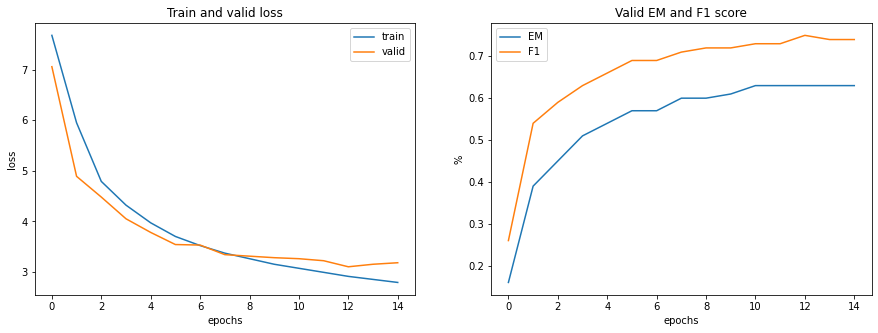

In [17]:
with open("./output/exp-1/all_scalars.json") as f:
    json_data = json.load(f)

epochs = [i for i in range(config.num_epochs)]
train_loss = [i[2] for i in json_data['output/exp-1/train/loss']]
valid_loss = [i[2] for i in json_data['output/exp-1/valid/loss']]
valid_em_scores = [i[2] for i in json_data['output/exp-1/valid/EM']]
valid_f1_scores = [i[2] for i in json_data['output/exp-1/valid/F1']]

fig, (ax1, ax2) = plt.subplots(figsize=(15,5),nrows=1, ncols=2)
ax1.set_title("Train and valid loss")
ax1.plot(epochs, train_loss, label="train")
ax1.plot(epochs, valid_loss, label="valid")
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

ax2.set_title("Valid EM and F1 score")
ax2.plot(epochs, valid_em_scores, label="EM")
ax2.plot(epochs, valid_f1_scores, label="F1")
ax2.set_xlabel('epochs')
ax2.set_ylabel('%')
ax2.legend()

# Evaluating using custom data 

In [18]:
def eval(context, question):
    with open(os.path.join(config.data_dir, "train", "word2idx.pkl"), "rb") as wi, \
         open(os.path.join(config.data_dir, "train", "char2idx.pkl"), "rb") as ci, \
         open(os.path.join(config.data_dir, "train", "word_embeddings.pkl"), "rb") as wb, \
         open(os.path.join(config.data_dir, "train", "char_embeddings.pkl"), "rb") as cb:
        word2idx = pickle.load(wi)
        char2idx = pickle.load(ci)
        word_embedding_matrix = pickle.load(wb)
        char_embedding_matrix = pickle.load(cb)

    # transform them into Tensors
    word_embedding_matrix = torch.from_numpy(np.array(word_embedding_matrix)).type(torch.float32)
    char_embedding_matrix = torch.from_numpy(np.array(char_embedding_matrix)).type(torch.float32)
    idx2word = dict([(y, x) for x, y in word2idx.items()])

    context = clean_text(context)
    context = [w for w in word_tokenize(context) if w]

    question = clean_text(question)
    question = [w for w in word_tokenize(question) if w]

    if len(context) > config.max_len_context:
        print("The context is too long. Maximum accepted length is", config.max_len_context, "words.")
    if max([len(w) for w in context]) > config.max_len_word:
        print("Some words in the context are longer than", config.max_len_word, "characters.")
    if len(question) > config.max_len_question:
        print("The question is too long. Maximum accepted length is", config.max_len_question, "words.")
    if max([len(w) for w in question]) > config.max_len_word:
        print("Some words in the question are longer than", config.max_len_word, "characters.")
    if len(question) < 3:
        print("The question is too short. It needs to be at least a three words question.")

    context_idx = np.zeros([config.max_len_context], dtype=np.int32)
    question_idx = np.zeros([config.max_len_question], dtype=np.int32)
    context_char_idx = np.zeros([config.max_len_context, config.max_len_word], dtype=np.int32)
    question_char_idx = np.zeros([config.max_len_question, config.max_len_word], dtype=np.int32)

    # replace 0 values with word and char IDs
    for j, word in enumerate(context):
        if word in word2idx:
            context_idx[j] = word2idx[word]
        else:
            context_idx[j] = 1
        for k, char in enumerate(word):
            if char in char2idx:
                context_char_idx[j, k] = char2idx[char]
            else:
                context_char_idx[j, k] = 1

    for j, word in enumerate(question):
        if word in word2idx:
            question_idx[j] = word2idx[word]
        else:
            question_idx[j] = 1
        for k, char in enumerate(word):
            if char in char2idx:
                question_char_idx[j, k] = char2idx[char]
            else:
                question_char_idx[j, k] = 1

    with torch.no_grad():
        context_idx, context_char_idx, question_idx, question_char_idx = torch.tensor(context_idx, dtype=torch.int64).unsqueeze(0).to(device),\
                                                                         torch.tensor(context_char_idx, dtype=torch.int64).unsqueeze(0).to(device),\
                                                                         torch.tensor(question_idx, dtype=torch.int64).unsqueeze(0).to(device),\
                                                                         torch.tensor(question_char_idx, dtype=torch.int64).unsqueeze(0).to(device)

        pred1, pred2 = model(context_idx, context_char_idx, question_idx, question_char_idx)
        starts, ends = discretize(pred1.exp(), pred2.exp(), 15, False)
        prediction = " ".join(context[starts.item(): ends.item() + 1])

    return prediction

In [21]:
if __name__ == "__main__":
    context = '''
    Christopher Columbus, born between 25 August and 31 October 1451, died 20 May 1506 was an Italian
    explorer and navigator who completed four Spanish-based voyages across the Atlantic Ocean sponsored by the Catholic Monarchs
    of Spain, opening the way for the widespread European exploration and colonization of the Americas.
    His expeditions were the first known European contact with the Caribbean, Central America, and South America.
    Columbus made three further voyages to the Americas, exploring the Lesser Antilles in 1493, Trinidad and the northern coast 
    of South America in 1498, and the eastern coast of Central America in 1502. Many of the names he gave to geographical features, 
    particularly islands, are still in use. He also gave the name indios ("Indians") to the indigenous peoples he encountered. 
    The extent to which he was aware that the Americas were a wholly separate landmass is uncertain; 
    he never clearly renounced his belief that he had reached the Far East. 
    As a colonial governor, Columbus was accused by his contemporaries of significant brutality and was soon removed from the post. 
    Columbus's strained relationship with the Crown of Castile and its appointed colonial administrators in America led to his arrest and removal
    from Hispaniola in 1500, and later to protracted litigation over the perquisites that he and his heirs claimed were owed to them by the crown. 
    '''

    questions = ["When was Christopher Columbus born?", "How many voyages did Christopher Columbus complete?",
                 "When did Christopher Columbus die?",
                 "Who sponsored the voyages?"]

    print("C:", context, "\n")
    for q in questions:
        print("Q:", q)
        answer = eval(context, q)
        print("A:", answer, "\n")

C: 
    Christopher Columbus, born between 25 August and 31 October 1451, died 20 May 1506 was an Italian
    explorer and navigator who completed four Spanish-based voyages across the Atlantic Ocean sponsored by the Catholic Monarchs
    of Spain, opening the way for the widespread European exploration and colonization of the Americas.
    His expeditions were the first known European contact with the Caribbean, Central America, and South America.
    Columbus made three further voyages to the Americas, exploring the Lesser Antilles in 1493, Trinidad and the northern coast 
    of South America in 1498, and the eastern coast of Central America in 1502. Many of the names he gave to geographical features, 
    particularly islands, are still in use. He also gave the name indios ("Indians") to the indigenous peoples he encountered. 
    The extent to which he was aware that the Americas were a wholly separate landmass is uncertain; 
    he never clearly renounced his belief that he had r